<a href="https://colab.research.google.com/github/felipemaiapolo/decomposing_dataset_shift/blob/main/Toy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Decomposing distributions shift into Covariate Shift and Expected Concept Drift

Loading packages

In [1]:
random_state=42

import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd
from tqdm import tqdm

## Decomposition

Being $P_{X,Y}$ the target joint distribution of features and label and $Q_{X,Y}$ the source joint distribution of features and label, we have that

\begin{align}
\text{D}_\text{KL}(P_{X,Y}||Q_{X,Y})&=\mathbb{E}_{P_{X,Y}}\left[\log \frac{p_{Y|X}(y|x)p_X(x)}{q_{Y|X}(y|x)q_X(x)}\right]\\[.5em]
&=\mathbb{E}_{P_{X,Y}}\left[\log \frac{p_{Y|X}(y|x)}{q_{Y|X}(y|x)}\right]+\mathbb{E}_{P_{X}}\left[\log \frac{p_X(x)}{q_X(x)}\right]\\[.5em]
&=\mathbb{E}_{P_{X}}\left[\text{D}_\text{KL}(P_{Y|X}||Q_{Y|X})\right]+\text{D}_\text{KL}(P_{X}||Q_{X})
\end{align}

Source: 
- Polyanskiy, Y., & Wu, Y. (2014). Lecture notes on information theory. Lecture Notes for ECE563 (UIUC) and, 6(2012-2016), 7. http://www.stat.yale.edu/~yw562/teaching/itlectures.pdf (Search for "Disintegration")
- https://math.stackexchange.com/questions/1804682/conditional-radon-nikodym-and-disintegration

## Toy Model Experiments

Consider the source distributions: 
\begin{align}
q_X(x)=\mathcal{N}(x|\mathbf{0}, \mathbf{I}_d) ~~~~~~ q_{Y|X}(y|x)=\mathcal{N}(y|x, 1) 
\end{align}

And then consider the target distributions: 
\begin{align}
p_X(x; \lambda)=\mathcal{N}(x|\lambda \cdot \mathbb{1}, \mathbf{I}_d) ~~~~~~ p_{Y|X}(y|x; \theta)=\mathcal{N}(y|\theta+x, 1) 
\end{align}

We can now decompose the joint distributions KL divergence as

\begin{align}
\text{D}_\text{KL}(P_{X,Y}||Q_{X,Y})&=\color{blue}{\mathbb{E}_{P_{X,Y}}\left[\log \frac{p_{Y|X}(y|x;\theta)}{q_{Y|X}(y|x)}\right]}+\color{red}{\mathbb{E}_{P_{X}}\left[\log \frac{p_X(x;\lambda)}{q_X(x)}\right]}\\[.5em]
&=\color{blue}{\frac{\theta^2}{2}} + \color{red}{\frac{d\lambda^2}{2}}
\end{align}

We assume $d=1$ in this notebook.

In [2]:
def conc_div(theta, lamb): return ((theta**2))/2 #(1+lamb**2)*
def cov_div(d,lamb): return (d*lamb**2)/2

### Experiment 1

Generating artificial data

In [3]:
n = 100000
theta = 1
lamb = 1

Source

In [4]:
Xs = np.random.normal(0,1,n)
ys = np.random.normal(Xs,1,n)

Target

In [5]:
Xt = np.random.normal(lamb,1,n)
yt = np.random.normal(theta + Xt,1,n)

Plotting Joint Distributions

In [6]:
df={'Distribution': n*['Source']+n*['Target'],
    'Label': n*[0]+n*[1],
    'X': np.hstack((Xs, Xt)),
    'y': np.hstack((ys, yt))}

df=pd.DataFrame(df)

In [7]:
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/My Drive/Mestrado/Thesis/Plots/"

Mounted at /content/drive


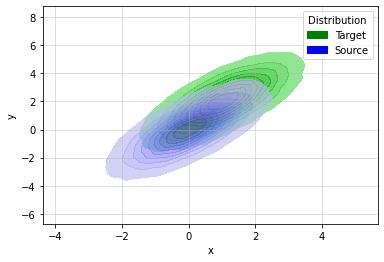

In [8]:
m=min(n,n)

sns.kdeplot(data=df.sample(n=m,replace=False), x="X", y="y", hue="Distribution", fill=True, alpha=.65, palette=['g','b'])
#plt.title('Comparing Source and Target joint distributions ($\lambda=1,~\Theta=1$)')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(alpha=.5)
plt.savefig(path+'decomp0.png', bbox_inches='tight', dpi=300, transparent=True)
plt.show()

Creating Test Set

In [9]:
m=100000
Xt_test = np.random.normal(lamb,1,m)
yt_test = np.random.normal(theta + Xt_test,1,m)

Xt_test=Xt_test.reshape(-1,1)
yt_test=yt_test.reshape(-1,1)

Zt_test=np.hstack((Xt_test, yt_test))
Zt_test.shape

(100000, 2)

Training w models

In [10]:
class w_model:
  def __init__(self):
    self.model=None
  
  def fit(self, Xw, yw, verbose=False):
    np.random.seed(random_state)

    Xw_train, Xw_val, yw_train, yw_val = train_test_split(Xw, yw, test_size=0.2, stratify=df.Label, random_state=random_state)

    self.model = xgb.XGBClassifier(learning_rate=0.05,
                              objective = 'binary:logistic', 
                              n_estimators=500,
                              n_jobs=-1,
                              random_state=random_state,
                              seed=random_state)
              
    self.model.fit(Xw_train, yw_train,
                    verbose=verbose,
                    early_stopping_rounds=15,
                    eval_metric='logloss',
                    eval_set=[(Xw_val, yw_val)])

  def predict(self, Z):
    p=self.model.predict_proba(Z)[:,1]
    return p/(1-p)

  def kl(self, Zt_test):
    n=Zt_test.shape[0]
    pred=self.predict(Zt_test)
    value=np.mean(np.log(pred))
    #error=np.std(np.log(pred))/np.sqrt(n)
    return value #, error

In [11]:
%%time

#Covariate Shift
Xw = np.array(df.X).reshape(-1,1)
yw = np.array(df.Label) #.reshape(-1,1)

w_cov = w_model()
w_cov.fit(Xw, yw)

#Total Shift
Xw = np.array(df.loc[:,['X','y']])
yw = np.array(df.Label) 

w_total = w_model()
w_total.fit(Xw, yw)


CPU times: user 26 s, sys: 86.6 ms, total: 26 s
Wall time: 13.9 s


Avaliando

In [ ]:
print("*** Covariate Shift ***")
print("Theoretical:{:.4f}  Empirical:{:.4f}".format(cov_div(1,lamb), w_cov.kl(Xt_test)))

print("\n*** Expected Concept Drift ***")
print("Theoretical:{:.4f}  Empirical:{:.4f}".format(conc_div(theta, lamb), w_total.kl(Zt_test)-w_cov.kl(Xt_test)))

### Experiment 2

Theoretical

In [ ]:
x=np.linspace(0,3,15)
T_total=[]
T_cov=[]

for t in x[::-1]:
  lista_total=[]
  lista_cov=[]
  for l in x:
    lista_total.append(cov_div(1,l) + conc_div(t, l))
    lista_cov.append(cov_div(1,l))
  
  T_total.append(lista_total)
  T_cov.append(lista_cov)

T_total=np.array(T_total)
T_cov=np.array(T_cov)
T_conc=T_total-T_cov

In [ ]:
T=[T_total, T_cov, T_conc]
titles=["Total Distribution Shift", "Covariate Shift", "Expected Concept Shift"]

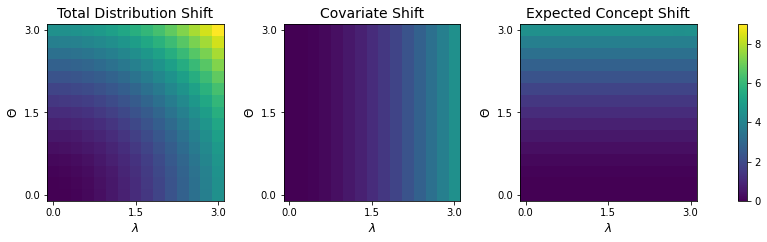

In [15]:
fig, axs = plt.subplots(1,3, sharex= True)
  
max=np.max(T_total)

for i in range(3):
  im=axs[i].imshow(T[i], cmap='viridis', vmin=0, vmax=max)
  axs[i].set_title(titles[i], size=14)
  axs[i].set_xlabel("$\lambda$", size=12)
  axs[i].set_ylabel("$\Theta$", size=12)

  ticks=[0,7,14]
  labels=np.round(x, 2)[ticks]
  axs[i].set_xticks(ticks)
  axs[i].set_xticklabels(labels)
  axs[i].set_yticks(ticks)
  axs[i].set_yticklabels(labels[::-1])
  
cbar = fig.colorbar(im, ax=axs.ravel().tolist())

fig.set_figheight(3.25)
fig.set_figwidth(15)
plt.savefig(path+'decomp1.png', bbox_inches='tight', dpi=300, transparent=True)
plt.show()

Empirical

In [16]:
E_total=[]
E_cov=[]

for t in tqdm(x[::-1]):
  lista_total=[]
  lista_cov=[]
  for l in x:
    ###Generating Training Data
    Xs = np.random.normal(0,1,n)
    ys = np.random.normal(Xs,1,n)
    Xt = np.random.normal(l,1,n)
    yt = np.random.normal(t+Xt,1,n)
    df={'Distribution': n*['Source']+n*['Target'],
        'Label': n*[0]+n*[1],
        'X': np.hstack((Xs, Xt)),
        'y': np.hstack((ys, yt))}
    df=pd.DataFrame(df)

    ### Generating Testing Data
    Xt_test = np.random.normal(l,1,n)
    yt_test = np.random.normal(t+Xt_test,1,n)
    Xt_test=Xt_test.reshape(-1,1)
    yt_test=yt_test.reshape(-1,1)
    Zt_test=np.hstack((Xt_test, yt_test))
 
    ### Training models
    #Covariate Shift
    Xw = np.array(df.X).reshape(-1,1)
    yw = np.array(df.Label) #.reshape(-1,1)
    w_cov = w_model()
    w_cov.fit(Xw, yw)

    #Total Shift
    Xw = np.array(df.loc[:,['X','y']])
    yw = np.array(df.Label) 
    w_total = w_model()
    w_total.fit(Xw, yw)

    #Storing
    lista_total.append(w_total.kl(Zt_test))
    lista_cov.append(w_cov.kl(Xt_test))

  E_total.append(lista_total)
  E_cov.append(lista_cov)

E_total=np.array(E_total)
E_cov=np.array(E_cov)
E_conc=E_total-E_cov

100%|██████████| 15/15 [1:16:51<00:00, 307.47s/it]


In [17]:
E=[E_total, E_cov, E_conc]

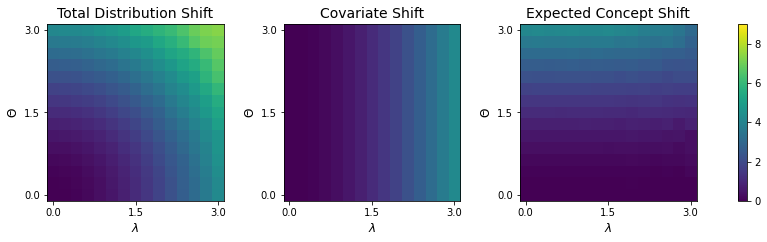

In [18]:
fig, axs = plt.subplots(1,3, sharex= True)
  
max=np.max(T_total)

for i in range(3):
  im=axs[i].imshow(E[i], cmap='viridis', vmin=0, vmax=max)
  axs[i].set_title(titles[i], size=14)
  axs[i].set_xlabel("$\lambda$", size=12)
  axs[i].set_ylabel("$\Theta$", size=12)

  ticks=[0,7,14]
  labels=np.round(x, 2)[ticks]
  axs[i].set_xticks(ticks)
  axs[i].set_xticklabels(labels)
  axs[i].set_yticks(ticks)
  axs[i].set_yticklabels(labels[::-1])
  
cbar = fig.colorbar(im, ax=axs.ravel().tolist())

fig.set_figheight(3.25)
fig.set_figwidth(15)
plt.savefig(path+'decomp2.png', bbox_inches='tight', dpi=300, transparent=True)
plt.show()

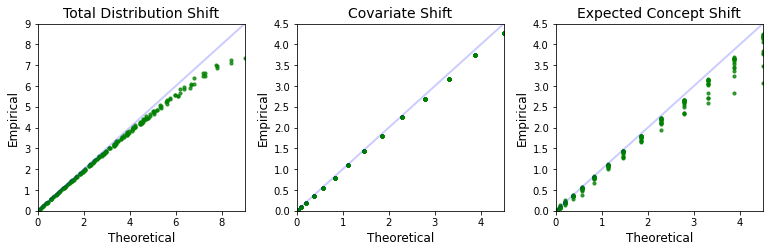

In [19]:
fig, axs = plt.subplots(1,3)

left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.25   # the amount of width reserved for blank space between subplots
hspace = 0.2   # the amount of height reserved for white space between subplots
plt.subplots_adjust(left, bottom, right, top, wspace, hspace)

for i in range(3):
  m=np.max(T[i]) #*1.05
  #print(T[i].shape, E[i].shape)
  axs[i].scatter(T[i].reshape(-1),E[i].reshape(-1), c='g', alpha=.75, s=10)
  axs[i].plot([0, m], [0, m], color = 'b', linewidth = 2, alpha=.2)
  axs[i].set_title(titles[i], size=14)
  axs[i].set_xlabel("Theoretical", size=12)
  axs[i].set_ylabel("Empirical", size=12)
  axs[i].set_xlim([0,m])
  axs[i].set_ylim([0,m])

fig.set_figheight(3.25)
fig.set_figwidth(13)
plt.savefig(path+'decomp3.png', bbox_inches='tight', dpi=300, transparent=True)
plt.show()